In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.utils as utils
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter

from attn_vgg import AttnVGG
from cub2011 import Cub2011

In [2]:
def visualize_attn_sigmoid(I, c, up_factor, nrow):
    # image
    img = I.permute((1,2,0)).cpu().numpy()
    # compute the heatmap
    a = torch.sigmoid(c)
    if up_factor > 1:
        a = F.interpolate(a, scale_factor=up_factor, mode='bilinear', align_corners=False)
    attn = utils.make_grid(a, nrow=nrow, normalize=False)
    attn = attn.permute((1,2,0)).mul(255).byte().cpu().numpy()
    attn = cv2.applyColorMap(attn, cv2.COLORMAP_JET)
    attn = cv2.cvtColor(attn, cv2.COLOR_BGR2RGB)
    attn = np.float32(attn) / 255
    # add the heatmap to the image
    vis = 0.6 * img + 0.4 * attn
    return torch.from_numpy(vis).permute(2,0,1)

def visualize_attn_softmax(I, c, up_factor, nrow):
    # image
    img = I.permute((1,2,0)).cpu().numpy()
    # compute the heatmap
    N,C,W,H = c.size()
    a = F.softmax(c.view(N,C,-1), dim=2).view(N,C,W,H)
    if up_factor > 1:
        a = F.interpolate(a, scale_factor=up_factor, mode='bilinear', align_corners=False)
    attn = utils.make_grid(a, nrow=nrow, normalize=True, scale_each=True)
    attn = attn.permute((1,2,0)).mul(255).byte().cpu().numpy()
    attn = cv2.applyColorMap(attn, cv2.COLORMAP_JET)
    attn = cv2.cvtColor(attn, cv2.COLOR_BGR2RGB)
    attn = np.float32(attn) / 255
    # add the heatmap to the image
    vis = 0.6 * img + 0.4 * attn
    return torch.from_numpy(vis).permute(2,0,1)

In [128]:
im_size = 64
transform_test = transforms.Compose([
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])
test_set = Cub2011(root='../../data', train=True, download=False, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=6, shuffle=True, num_workers=0)

In [91]:
torch.cuda.empty_cache()

In [83]:
model = AttnVGG(im_size=im_size, num_classes=200, normalize_attn=False)
checkpoint = torch.load('./checkpoints/cub_pretrained_attempt_5/cub_attn-net_epoch_90.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.cuda()
model.eval()

AttnVGG(
  (conv_block1): ConvBlock(
    (op): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (conv_block2): ConvBlock(
    (op): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (conv_block3): ConvBlock(
    (op): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [129]:
i = 0
for images, labels in test_loader:
    if i == 100:
        break
    i += 1

In [130]:
pil_img = utils.make_grid(images, nrow=6, normalize=True, scale_each=True)

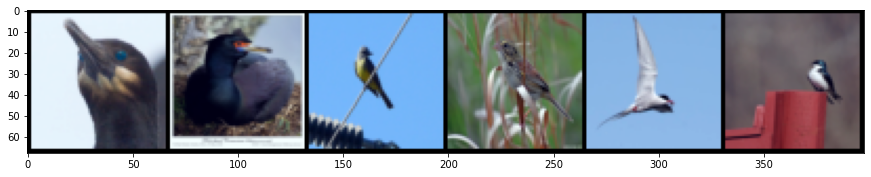

In [131]:
plt.figure(figsize=[15, 20])
plt.imshow(transforms.ToPILImage()(pil_img))

In [132]:
pred, c1, c2, c3 = model(images.cuda())

In [133]:
torch.argmax(pred, dim=1)

tensor([ 22,  23,  76, 122, 140, 137], device='cuda:0')

In [134]:
labels

tensor([ 22,  23,  76, 122, 140, 137])

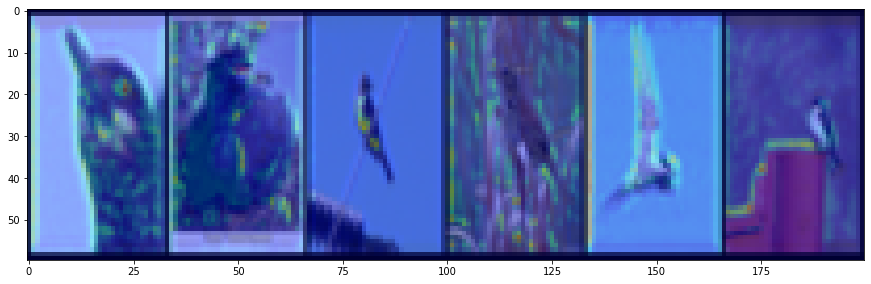

In [135]:
attn1 = visualize_attn_softmax(pil_img, c1, up_factor=1, nrow=6)
plt.figure(figsize=[15, 20])
plt.imshow(transforms.Resize((60, 200))(transforms.ToPILImage()(attn1)))

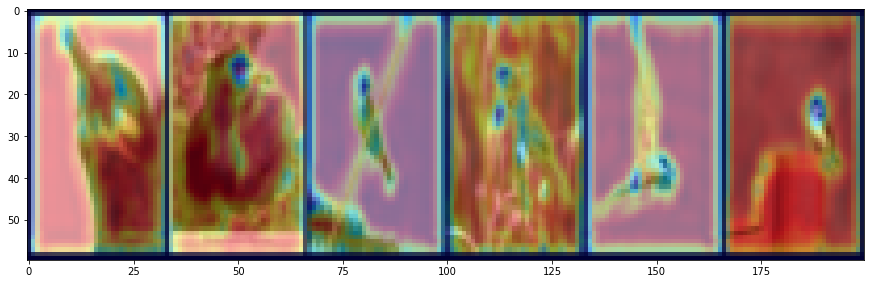

In [136]:
attn2 = visualize_attn_softmax(pil_img, c2, up_factor=2, nrow=6)
plt.figure(figsize=[15, 20])
plt.imshow(transforms.Resize((60, 200))(transforms.ToPILImage()(attn2)))

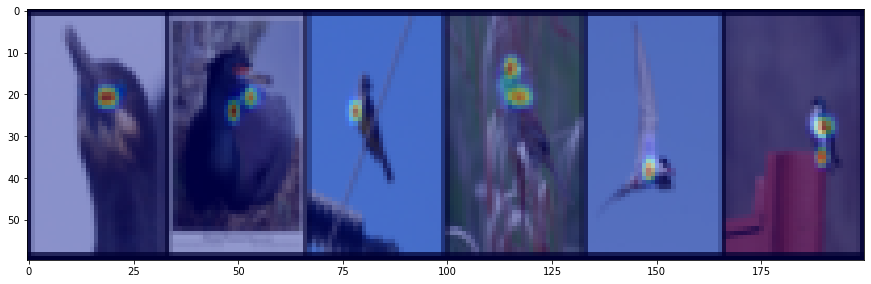

In [137]:
attn3 = visualize_attn_softmax(pil_img, c3, up_factor=4, nrow=6)
plt.figure(figsize=[15, 20])
plt.imshow(transforms.Resize((60, 200))(transforms.ToPILImage()(attn3)))